# Negative Fake Companion Technique 
## Using GPU

In [4]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import numpy as np
import os

from vip_hci.fits import open_fits

from vip.plottools import create_circular_mask 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import gpu.fake_comp as tfnegfc


os.environ["CUDA_VISIBLE_DEVICES"] = "3"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data

In [6]:
root = './data/HCI/'

cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 90, 201, 201)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (90,)


### Normalizing PSF: Creating a template to mimic companions 

The first step consists in creating the fake companion template we will use later to mimic the real one.

We need first to find the real center and standard deviation of the PSF by fitting a gaussian model on pixels, 

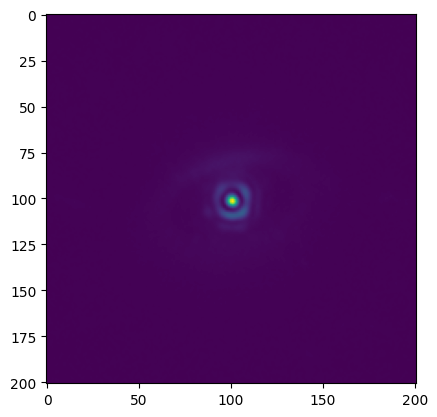

In [7]:
plt.figure(dpi=100)
plt.imshow(cube[0, 0])

In [8]:
results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])

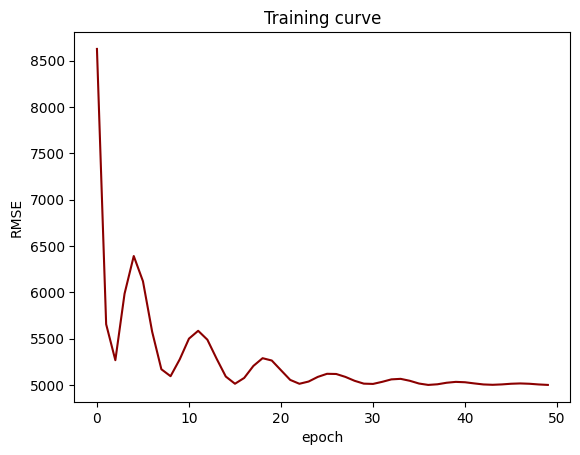

In [9]:
plt.plot(results['history'], color='darkred')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Training curve')
plt.show()

Assuming an sphere (i.e., same FWHM along the PSFs) we center all the availables PSFs. This is not used yet, but worth for future work:

In [10]:
fwhm_sphere  = tf.reduce_mean(results['fwhm'])
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)
centered_psf.shape

TensorShape([2, 64, 64])

Once all the PSFs were aligned we can normalize it to have a 1-FWHM in an aperture equal to FWHM//2

In [11]:
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)

### PCA: Extracting most variable pixels along the time axis from the cube of frames

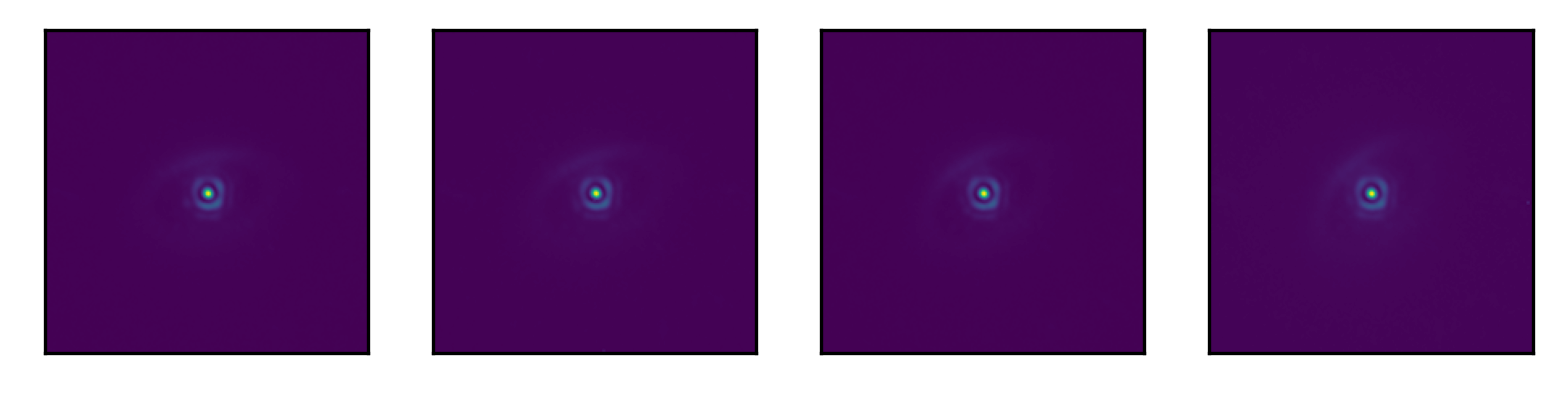

In [12]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, dpi=300)
axes = axes.flatten()
for i, nf in enumerate(range(0, len(cube[0]), 10)):
    try:
        axes[i].imshow(cube[0, nf])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    except:
        break

In [13]:
cube[0].shape

(90, 201, 201)

In [14]:
%%time
adi_image = tfnegfc.apply_adi(cube[0], rot_ang, out_size=cube[0].shape, ncomp=1, derotate='tf')

CPU times: user 843 ms, sys: 118 ms, total: 961 ms
Wall time: 488 ms


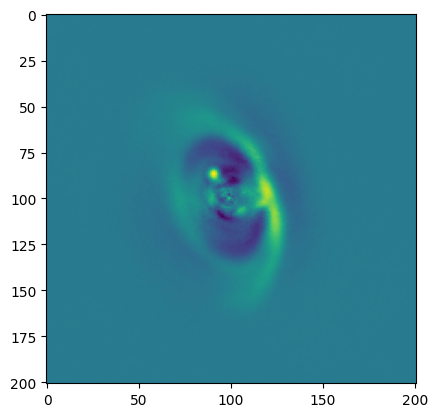

In [15]:
plt.imshow(adi_image)

In [16]:
%%time
table = tfnegfc.get_coords(adi_image.numpy(), fwhm=fwhm_sphere, bkg_sigma=5, cut_size=10)

CPU times: user 2.98 s, sys: 73.7 ms, total: 3.05 s
Wall time: 2.8 s


In [17]:
table

,x,y,flux,fwhm_mean,snr
0,91.430801,86.833885,3.315128,4.139935,2.715647
1,106.392311,106.029007,1.466266,4.254247,1.737471
2,89.601730,99.557098,1.275057,4.414629,1.308851


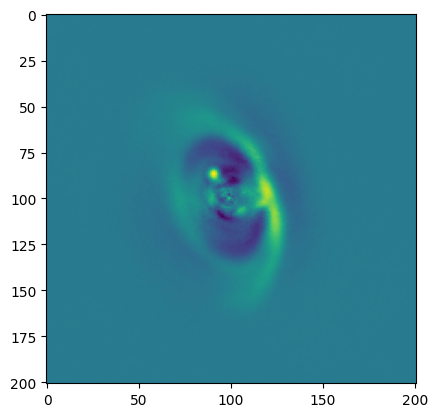

In [18]:
plt.figure()
plt.imshow(adi_image)
plt.show()

### Fiting parameters

In [77]:
from tensorflow.keras.optimizers import Adam 
from gpu.negfc_models import get_model
from gpu.losses import custom_loss
from gpu.data import get_dataset

In [78]:
def wrapper(fn, fwhm):
    def inner(*args):
        out = fn(*args, fwhm=fwhm)
        return out
    return inner

In [79]:
custom_loss_w = wrapper(custom_loss, fwhm=table.iloc[0]['fwhm_mean']*3)

dataset, recovery = get_dataset(cube, normalized_psf, rot_ang, normalize=0)

model = get_model(x_init=table.iloc[0]['x'], 
                  y_init=table.iloc[0]['y'], 
                  cube=cube)    
model.compile(loss_fn=custom_loss_w, optimizer=Adam(1))
# model.summary()

2023-05-11 16:27:58.520996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'angular_differential_imaging_8/map/while/Reshape/shape/angular_differential_imaging_8/strided_slice' with dtype int32
	 [[{{node angular_differential_imaging_8/map/while/Reshape/shape/angular_differential_imaging_8/strided_slice}}]]
2023-05-11 16:27:58.521082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'angular_differential_imaging_8/map/while/Reshape/shape/angular_differential_imaging_8/strided_slice_1' with dtype int32
	 [[{{node angular_differential_imaging_8/map/while/Reshape/shape/angular_differential_imaging_8/strided_slice_1}}]]
2023

In [80]:
%%time
hist = model.fit(dataset, epochs=300, verbose=1)

Epoch 1/300


2023-05-11 16:28:00.088771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [1,90]
	 [[{{node Placeholder/_2}}]]
2023-05-11 16:28:00.190309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'negfc_model/angular_differential_imaging_8/map/while/Reshape/shape/negfc_model/angular_differential_imaging_8/strided_slice' with dtype int32
	 [[{{node negfc_model/angular_differential_imaging_8/map/while/Reshape/shape/negfc_model/angular_differential_imaging_8/strided_slice}}]]
2023-05-11 16:28:00.190400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Execu

1/1 [==============================] - 3s 3s/step - loss: 0.8849
Epoch 2/300
1/1 [==============================] - 1s 675ms/step - loss: 0.8807
Epoch 3/300
1/1 [==============================] - 1s 563ms/step - loss: 0.8765
Epoch 4/300
1/1 [==============================] - 1s 619ms/step - loss: 0.8723
Epoch 5/300
1/1 [==============================] - 1s 614ms/step - loss: 0.8681
Epoch 6/300
1/1 [==============================] - 1s 522ms/step - loss: 0.8638
Epoch 7/300
1/1 [==============================] - 1s 571ms/step - loss: 0.8596
Epoch 8/300
1/1 [==============================] - 1s 548ms/step - loss: 0.8556
Epoch 9/300
1/1 [==============================] - 1s 560ms/step - loss: 0.8516
Epoch 10/300
1/1 [==============================] - 1s 621ms/step - loss: 0.8476
Epoch 11/300
1/1 [==============================] - 1s 603ms/step - loss: 0.8437
Epoch 12/300
1/1 [==============================] - 1s 637ms/step - loss: 0.8399
Epoch 13/300
1/1 [==============================] - 

1/1 [==============================] - 1s 586ms/step - loss: 0.6826
Epoch 103/300
1/1 [==============================] - 1s 604ms/step - loss: 0.6825
Epoch 104/300
1/1 [==============================] - 1s 582ms/step - loss: 0.6823
Epoch 105/300
1/1 [==============================] - 1s 531ms/step - loss: 0.6822
Epoch 106/300
1/1 [==============================] - 1s 593ms/step - loss: 0.6821
Epoch 107/300
1/1 [==============================] - 1s 577ms/step - loss: 0.6820
Epoch 108/300
1/1 [==============================] - 1s 561ms/step - loss: 0.6818
Epoch 109/300
1/1 [==============================] - 1s 516ms/step - loss: 0.6817
Epoch 110/300
1/1 [==============================] - 1s 556ms/step - loss: 0.6816
Epoch 111/300
1/1 [==============================] - 1s 519ms/step - loss: 0.6816
Epoch 112/300
1/1 [==============================] - 1s 545ms/step - loss: 0.6815
Epoch 113/300
1/1 [==============================] - 1s 587ms/step - loss: 0.6814
Epoch 114/300
1/1 [===========

1/1 [==============================] - 1s 601ms/step - loss: 0.6803
Epoch 203/300
1/1 [==============================] - 1s 519ms/step - loss: 0.6803
Epoch 204/300
1/1 [==============================] - 1s 512ms/step - loss: 0.6803
Epoch 205/300
1/1 [==============================] - 1s 536ms/step - loss: 0.6803
Epoch 206/300
1/1 [==============================] - 1s 539ms/step - loss: 0.6803
Epoch 207/300
1/1 [==============================] - 1s 545ms/step - loss: 0.6803
Epoch 208/300
1/1 [==============================] - 1s 587ms/step - loss: 0.6803
Epoch 209/300
1/1 [==============================] - 0s 499ms/step - loss: 0.6803
Epoch 210/300
1/1 [==============================] - 1s 517ms/step - loss: 0.6803
Epoch 211/300
1/1 [==============================] - 1s 517ms/step - loss: 0.6803
Epoch 212/300
1/1 [==============================] - 1s 552ms/step - loss: 0.6803
Epoch 213/300
1/1 [==============================] - 1s 526ms/step - loss: 0.6803
Epoch 214/300
1/1 [===========

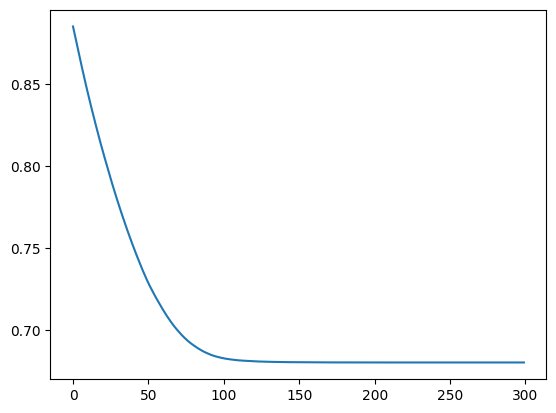

In [81]:
plt.plot(hist.history['loss'])

In [82]:
x = model.trainable_variables[0]
y = model.trainable_variables[1]
flux = model.trainable_variables[2]#*(maxv[0]-minv[0]) + minv[0]
flux = flux[0]
print('flux: {}'.format(flux))

flux: 89.57574462890625


In [83]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_zeros = tfnegfc.inject_fake(x=x, y=y, flux = -flux, 
                                cube=tf.zeros_like(cube[0]), 
                                patch=patch, 
                                rot_angles=rot_ang)
adi_image_fake_zeros = tfnegfc.apply_adi(fake_zeros, 
                                   rot_ang, 
                                   out_size=(cube[0].shape),
                                   ncomp=1, 
                                   derotate='tf')

fake_cube = tfnegfc.inject_fake(x=x, y=y, flux = -flux, 
                                cube=cube[0], 
                                patch=patch, 
                                rot_angles=rot_ang)

adi_image_fake = tfnegfc.apply_adi(fake_cube, 
                                   rot_ang, 
                                   out_size=(cube[0].shape),
                                   ncomp=1, 
                                   derotate='tf')

Text(0.5, 1.0, 'Residuals')

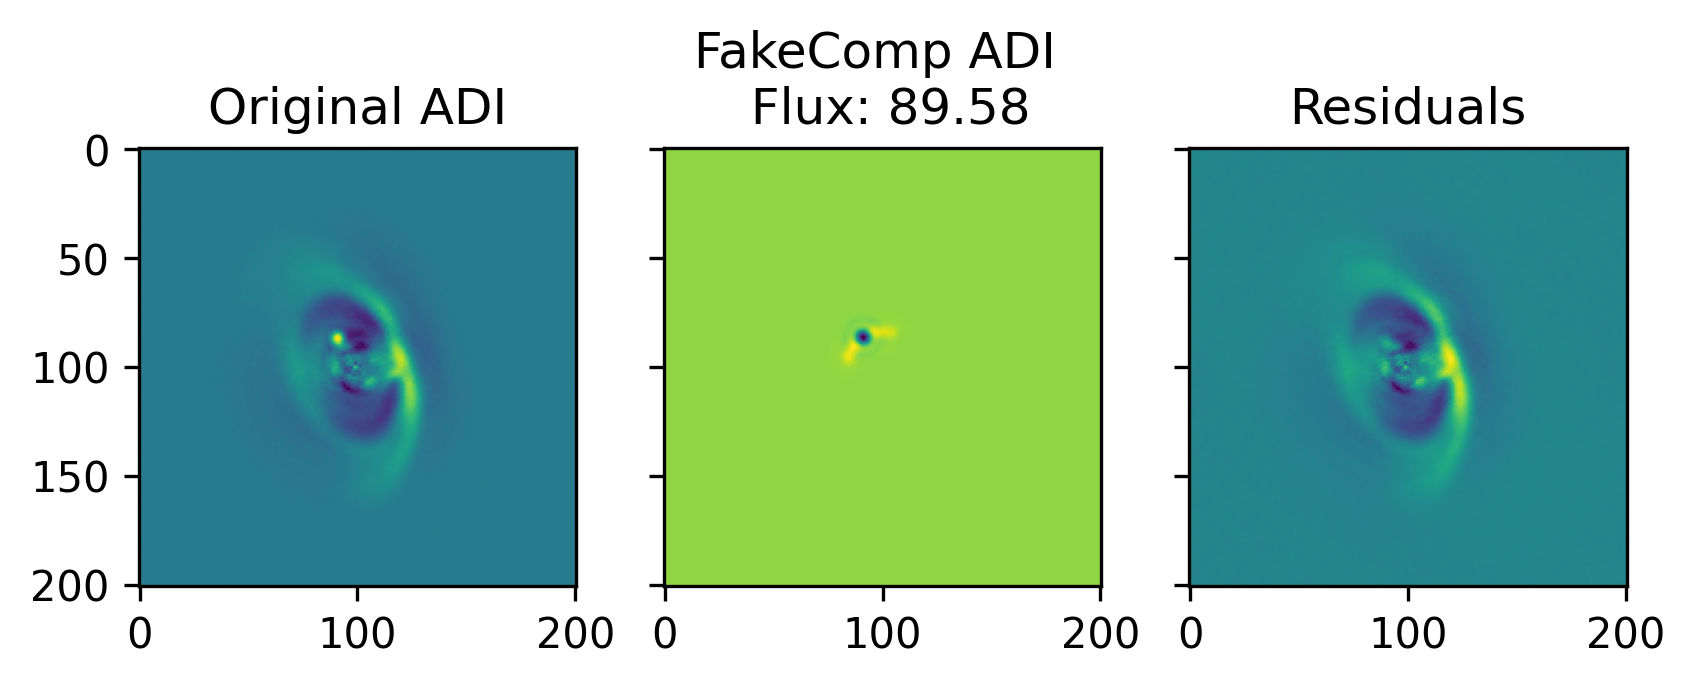

In [95]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(adi_image)
axes[0].set_title('Original ADI')
axes[1].imshow(adi_image_fake_zeros)
axes[1].set_title('FakeComp ADI \n Flux: {:.2f}'.format(flux))
axes[2].imshow(adi_image+adi_image_fake_zeros)
axes[2].set_title('Residuals')
# plt.scatter(x, y, marker='x', color='red')

### MCMC

In [86]:
import tensorflow_probability as tfp
import tensorflow as tf

In [87]:
def log_prob_flux_only(flux):        
    rv_flux = tfp.distributions.Normal(loc=flux, scale=2)
    if tf.math.less(flux, 0.):
        return -np.inf
    return rv_flux.log_prob(flux)

def log_prob_fn(x, y, flux):        
    rv_x = tfp.distributions.Normal(loc=x, scale=.1)
    rv_y = tfp.distributions.Normal(loc=y, scale=.1)
    rv_flux = tfp.distributions.Normal(loc=flux, scale=1)
    return (rv_x.log_prob(x) + rv_y.log_prob(y) + rv_flux.log_prob(flux))

In [88]:
def likelihood_flux_only(flux, x, y, fwhm, cube, patch, rot_ang):    
    fake_cube = tfnegfc.inject_fake(x=x, 
                                    y=y, 
                                    flux = -flux, 
                                    cube=cube, 
                                    patch=patch, 
                                    rot_angles=rot_ang)
    obj_reg = tfnegfc.get_objective_region(fake_cube, x=x, y=y, rot_ang=rot_ang, fwhm=fwhm, nfwhm=1)
    return -tf.math.reduce_std(obj_reg)

def likelihood_fn(x, y, flux, fwhm, cube, patch, rot_ang):    
    fake_cube = tfnegfc.inject_fake(x=x, 
                                    y=y, 
                                    flux = -flux, 
                                    cube=cube, 
                                    patch=patch, 
                                    rot_angles=rot_ang)
    obj_reg = tfnegfc.get_objective_region(fake_cube, x=x, y=y, rot_ang=rot_ang, fwhm=fwhm, nfwhm=1)
    return -tf.math.reduce_std(obj_reg)

In [89]:
def joint_log_prob_fn(x, y, flux, fwhm, cube, patch, rot_angle):
    
    return log_prob_fn(x, y, flux) + likelihood_fn(x,y,flux, fwhm, cube, patch, rot_angle)

def joint_log_prob_flux_only(flux, x, y, fwhm, cube, patch, rot_angle):
    
    return log_prob_flux_only(flux) + likelihood_flux_only(flux, x,y, fwhm, cube, patch, rot_angle)

In [90]:
@tf.function
def run_chain_only_flux(initial_state, x, y, fwhm, cube, normalized_psf, 
                        rot_ang, num_results=1000, num_burnin_steps=500):
    
    initial_state = [tf.cast(x, tf.float32) for x in initial_state]
    fake_patch = tfnegfc.create_patch(cube[0], normalized_psf)
        
    # Define a closure over our joint_log_prob.
    unconstraining_bijectors = [
      tfp.bijectors.Identity()
    ]
    unnormalized_posterior_log_prob = lambda *args: joint_log_prob_flux_only(*args, x, y, 
                                                                             fwhm, cube, 
                                                                             fake_patch,
                                                                             rot_ang)
    
    # Define the HMC transition kernel.
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_posterior_log_prob,
      num_leapfrog_steps=2,
      step_size=0.1)
    
    # Define the MCMC transition kernel.
    mcmc_kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc_kernel,
      bijector=unconstraining_bijectors)
    
    # Define the initial state of the chain.
    current_state = initial_state
    
    # Sample from the chain.
    samples = tfp.mcmc.sample_chain(
                  num_results=num_results,
                  num_burnin_steps=num_burnin_steps,
                  current_state=current_state,
                  kernel=mcmc_kernel)
    return samples

@tf.function
def run_chain(initial_state, fwhm, cube, normalized_psf, rot_ang, num_results=1000, num_burnin_steps=500):
    initial_state = [tf.cast(x, tf.float32) for x in initial_state]
    fake_patch = tfnegfc.create_patch(cube[0], normalized_psf)
        
    # Define a closure over our joint_log_prob.
    unconstraining_bijectors = [
      tfp.bijectors.Identity(),
      tfp.bijectors.Identity(),
      tfp.bijectors.Identity()
    ]
    unnormalized_posterior_log_prob = lambda *args: joint_log_prob_fn(*args, fwhm, cube, fake_patch,rot_ang)
    
    # Define the HMC transition kernel.
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_posterior_log_prob,
      num_leapfrog_steps=2,
      step_size=0.1)
    
    # Define the MCMC transition kernel.
    mcmc_kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc_kernel,
      bijector=unconstraining_bijectors)
    
    # Define the initial state of the chain.
    current_state = initial_state
    
    # Sample from the chain.
    samples = tfp.mcmc.sample_chain(
                  num_results=num_results,
                  num_burnin_steps=num_burnin_steps,
                  current_state=current_state,
                  kernel=mcmc_kernel)
    return samples

In [43]:
# %%time
# init_state = [table.iloc[0]['x'], table.iloc[0]['y'], table.iloc[0]['flux']]
# results = run_chain(init_state, table.iloc[0]['fwhm_mean'], cube[0], normalized_psf[0], 
#                     rot_ang, num_results=1000)

In [117]:
%%time
init_state = [flux]

results = run_chain_only_flux(init_state, 
                              x, 
                              y, 
                              table.iloc[0]['fwhm_mean'], 
                              cube[0], 
                              normalized_psf[0], 
                              rot_ang, 
                              num_results=500)

/home/cridonoso/miniconda3/envs/moon/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
2023-05-11 16:39:20.542908: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: mcmc_sample_chain/transformed_kernel_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/cond_1/branch_executed/_34


CPU times: user 19min 31s, sys: 27.8 s, total: 19min 59s
Wall time: 2min 3s


In [118]:
start = 0
samples = [r[start:] for r in results.all_states]
opt_values = [np.mean(samples_chain) for samples_chain in samples]

for initial_val, final_val in zip(init_state, opt_values):
    print(initial_val,' - ', final_val)

tf.Tensor(89.575745, shape=(), dtype=float32)  -  81.79439


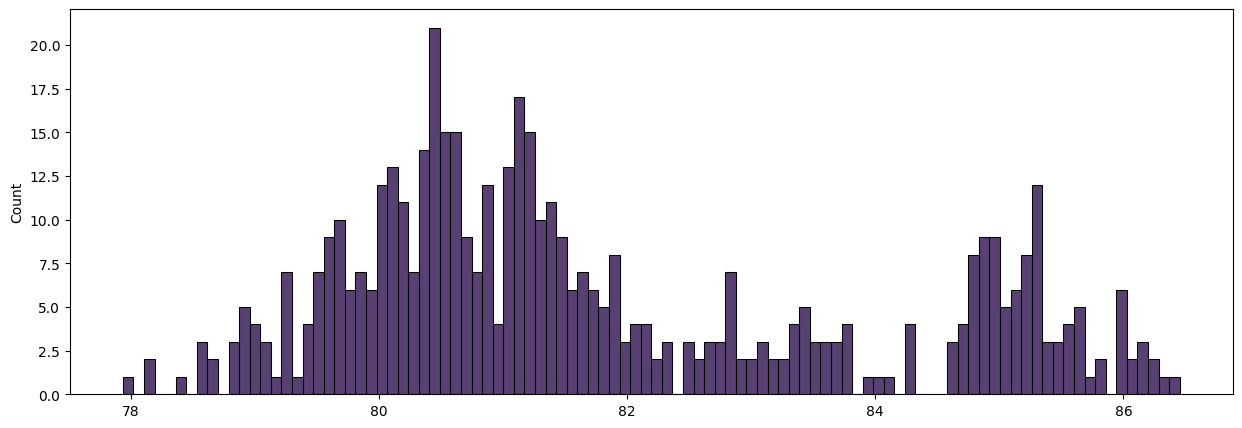

In [135]:
import seaborn as sns
fig, axes = plt.subplots(1, len(init_state), figsize=(15,5))
if len(init_state)>1: 
    axes = axes.flatten()
else:
    axes = [axes]
    
for i, r in enumerate(samples):
    sns.histplot(np.ravel(r) , ax=axes[i], kde=False, bins=100, color='#200044')
    break

## Visualizing Results

In [136]:
x_star = x
y_star = y
flux_star = opt_values[0]

In [139]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_cube = tfnegfc.inject_fake(x = x_star, 
                                y = y_star, 
                                flux  = -flux_star, 
                                cube  = cube[0], 
                                patch = fake_patch, 
                                rot_angles = rot_ang)

fake_cube_adi = tfnegfc.apply_adi(fake_cube, 
                                  rot_ang, 
                                  out_size=(cube[0].shape),
                                  ncomp=1, 
                                  derotate='tf')

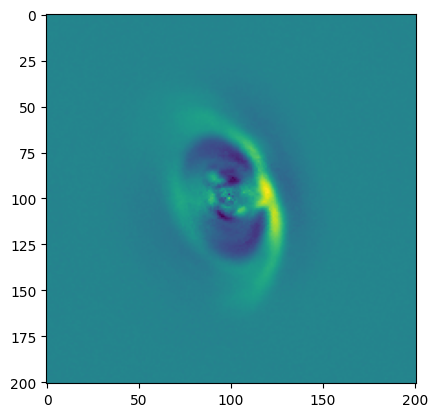

In [140]:
plt.imshow(fake_cube_adi)